In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

import tonic.transforms as transforms
from deep_models.training_datasets import VPRDataset

In [2]:
# Load the query and reference data
dir_to_load_from = './data/input_parquet_files/'

reference_traverse = ["sunset1"]
query_traverse = ["sunset2"]

ref_dataset = VPRDataset(reference_traverse, n_places=25, time_window=0.3, n_hist=1, format="pickle")
query_dataset = VPRDataset(query_traverse, n_places=25, time_window=0.3, n_hist=1, format="pickle")

Processing traverse sunset1
Processing traverse sunset2


In [11]:
def convert_dataset_list(dataset: VPRDataset) -> np.array:
    return np.array([np.array(item[0]) for item in dataset])

frames_qry_30ms = convert_dataset_list(query_dataset)
frames_ref_30ms = convert_dataset_list(ref_dataset)
print(ref_frames.shape)

(25, 2, 260, 346)
(25, 2, 260, 346)


In [4]:
frame_transform_66ms = transforms.ToFrame(sensor_size=sensor_size, time_window=66e3)
frame_transform_1000ms = transforms.ToFrame(sensor_size=sensor_size, time_window=1000e3)
frames_qry_66ms = frame_transform_66ms(events_qry)
frames_ref_66ms = frame_transform_66ms(events_ref)
frames_qry_1000ms = frame_transform_1000ms(events_qry)
frames_ref_1000ms = frame_transform_1000ms(events_ref)

frames_qry_66ms.shape

(2487, 2, 260, 346)

In [5]:
# Create an ipywidget to visualize the frames
def plot_frame(frame_index):
    frame = frames_qry_66ms[frame_index]
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(frame[1] - frame[0])
    ax.axis("off")
    plt.show()

# Create a slider for frame selection
frame_slider = widgets.IntSlider(min=0, max=frames_qry_66ms.shape[0]-1, step=1, value=0, description='Frame #:')

# Display the widget
interactive_plot = interactive(plot_frame, frame_index=frame_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Frame #:', max=2486), Output()), _dom_classes=('widget-i…

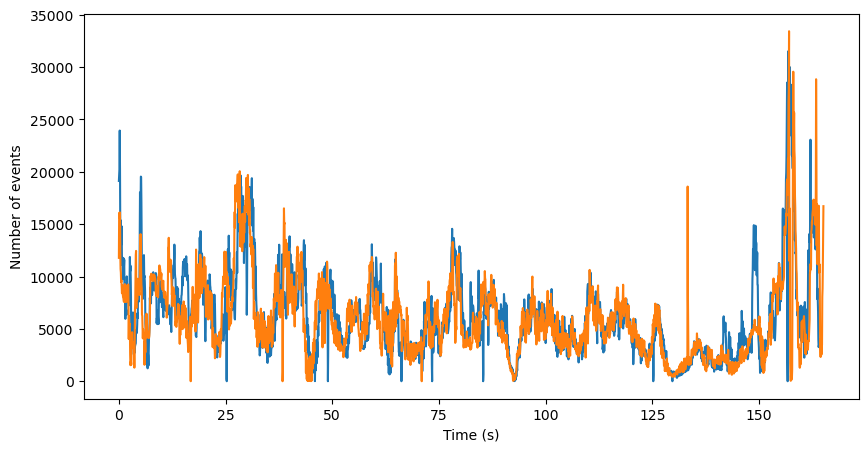

In [7]:
# Let's plot the number of events over time
def plot_events_over_time(event_frames_list, time_window):
    plt.figure(figsize=(10, 5))
    # x axis: time in seconds
    # y axis: number of events (sum of all pixels in an event frame)
    for event_frames in event_frames_list:
        if len(event_frames.shape) == 4:  # if the event_frames are in the format (n_frames, height, width, polarity)
            plt.plot(np.arange(event_frames.shape[0]) * time_window / 1e6, np.sum(event_frames[:, 1], axis=(1, 2)))
        else: # if the event_frames are in the format (n_frames, height, width)
            plt.plot(np.arange(event_frames.shape[0]) * time_window / 1e6, np.sum(event_frames, axis=1))
    plt.xlabel('Time (s)')
    plt.ylabel('Number of events')
    plt.show()

plot_events_over_time([frames_qry_66ms, frames_ref_66ms], time_window=66e3)

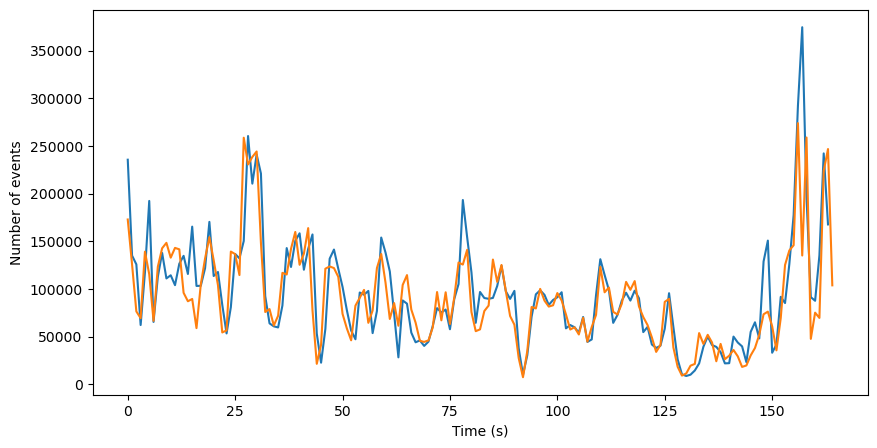

In [8]:
plot_events_over_time([frames_qry_1000ms, frames_ref_1000ms], time_window=1000e3)

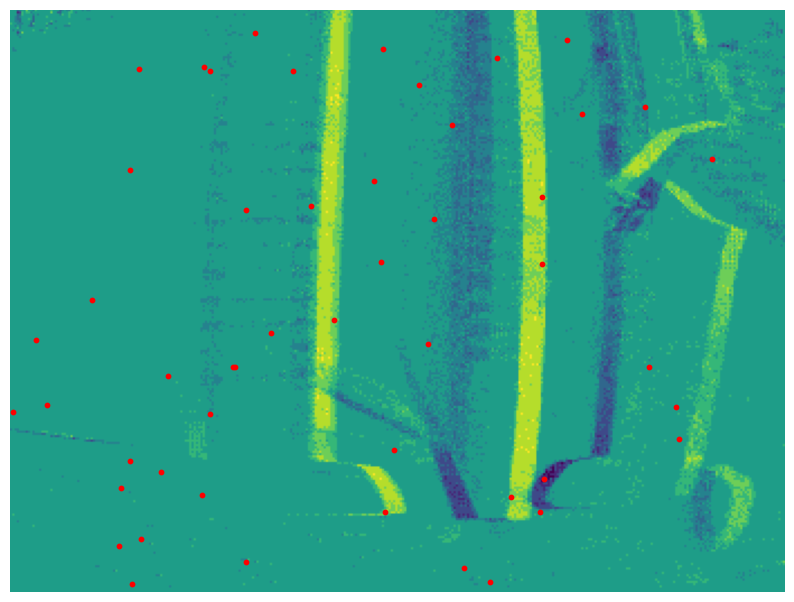

In [9]:
# Let's pick N random pixels
N = 50
random_pixels = []
for _ in range(N):
    random_idx_flat = np.random.choice(np.arange(0, sensor_size[0] * sensor_size[1]))
    random_pixel = np.unravel_index(random_idx_flat, (sensor_size[0], sensor_size[1]))
    random_pixels.append(random_pixel)

# Let's visualise the random pixel locations
def plot_random_pixels(random_pixels):
    plt.figure(figsize=(10, 10))
    plt.imshow(frames_qry_66ms[0, 1] - frames_qry_66ms[0, 0])
    for pixel in random_pixels:
        plt.scatter(pixel[0], pixel[1], c='r', s=10)
    plt.axis("off")
    plt.show()

plot_random_pixels(random_pixels)

In [10]:
# Now let's create event frames that only contain the events of the random pixels
def create_frames_subset(frames, random_pixels):
    frames_subset = np.zeros((len(frames), len(random_pixels)))
    for frame_idx in range(len(frames)):
        for p_idx in range(len(random_pixels)):
            frames_subset[frame_idx, p_idx] = frames[frame_idx, random_pixels[p_idx][1], random_pixels[p_idx][0]]
    return frames_subset

# Let's ignore the polarity for now
frames_qry_66ms_nopol = np.sum(frames_qry_66ms, axis=1)
frames_ref_66ms_nopol = np.sum(frames_ref_66ms, axis=1)

frames_qry_1000ms_nopol = np.sum(frames_qry_1000ms, axis=1)
frames_ref_1000ms_nopol = np.sum(frames_ref_1000ms, axis=1)

# Create the event frames for the random pixels by selecting the number of events occuring at the random pixels
frames_random_pixels_qry_66ms = create_frames_subset(frames_qry_66ms_nopol, random_pixels)
frames_random_pixels_ref_66ms = create_frames_subset(frames_ref_66ms_nopol, random_pixels)

frames_random_pixels_qry_1000ms = create_frames_subset(frames_qry_1000ms_nopol, random_pixels)
frames_random_pixels_ref_1000ms = create_frames_subset(frames_ref_1000ms_nopol, random_pixels)

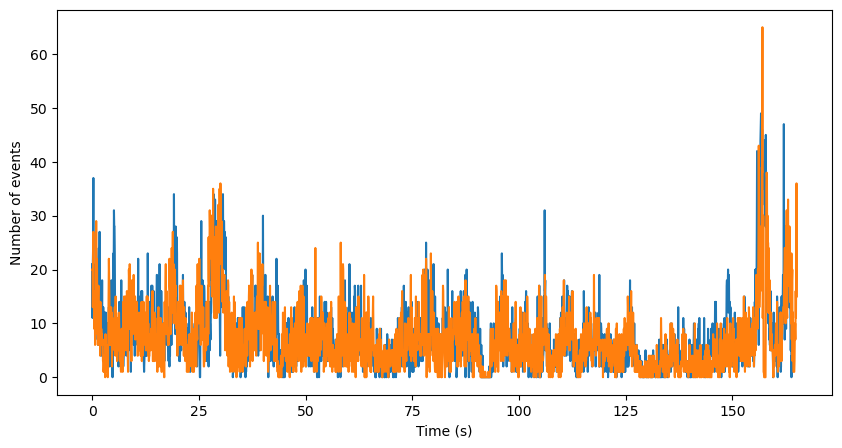

In [11]:
plot_events_over_time([frames_random_pixels_qry_66ms, frames_random_pixels_ref_66ms], time_window=66e3)

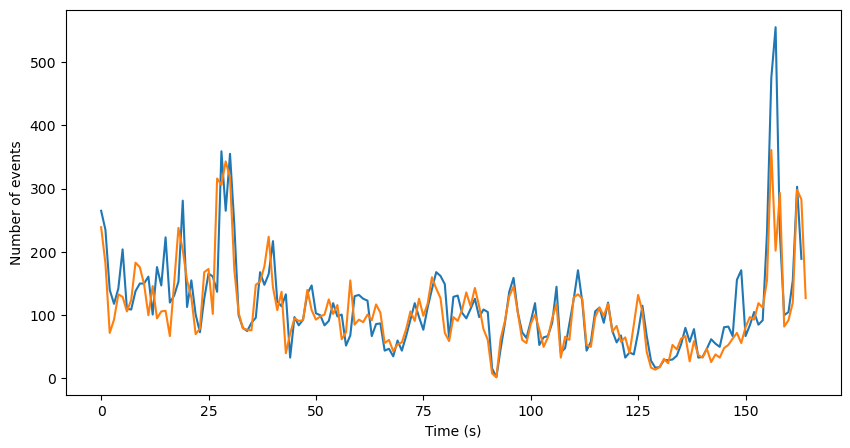

In [12]:
plot_events_over_time([frames_random_pixels_qry_1000ms, frames_random_pixels_ref_1000ms], time_window=1000e3)

In [13]:
# Now let's calculate a distance matrix between the query and reference event frames
# Each column of the distance matrix corresponds to a query event frame
# Each row of the distance matrix corresponds to a reference event frame

def calculate_distance_matrix_slow(event_frames_qry, event_frames_ref):
    distance_matrix = np.zeros((event_frames_qry.shape[0], event_frames_ref.shape[0]))
    for i in range(event_frames_qry.shape[0]):
        for j in range(event_frames_ref.shape[0]):
            # Use the Sum of Absolute Differences (SAD) as distance metric
            distance_matrix[j, i] = np.sum(np.abs(event_frames_qry[i] - event_frames_ref[j]))
    return distance_matrix

def calculate_distance_matrix_fast(event_frames_qry, event_frames_ref):
    # Use the Sum of Absolute Differences (SAD) as distance metric
    distance_matrix = np.sum(np.abs(event_frames_ref[:, None] - event_frames_qry[None]), axis=2)
    return distance_matrix

def caculate_distance_matrix_torch(event_frames_qry, event_frames_ref):
    ref = torch.from_numpy(event_frames_ref.reshape(event_frames_ref.shape[0], -1).astype(np.float32)).unsqueeze(0)
    qry = torch.from_numpy(event_frames_qry.reshape(event_frames_qry.shape[0], -1).astype(np.float32)).unsqueeze(0)
    return torch.cdist(qry, ref, 1)[0].numpy()

distance_matrix_fast_random_pixels_66ms = calculate_distance_matrix_fast(frames_random_pixels_qry_66ms, frames_random_pixels_ref_66ms)
distance_matrix_fast_random_pixels_1000ms = calculate_distance_matrix_fast(frames_random_pixels_qry_1000ms, frames_random_pixels_ref_1000ms)
# distance_matrix_slow = calculate_distance_matrix_slow(event_frames_random_pixels_qry, event_frames_random_pixels_ref)

In [17]:
distance_matrix_all_pixels_66ms = caculate_distance_matrix_torch(frames_qry_66ms_nopol, frames_ref_66ms_nopol)

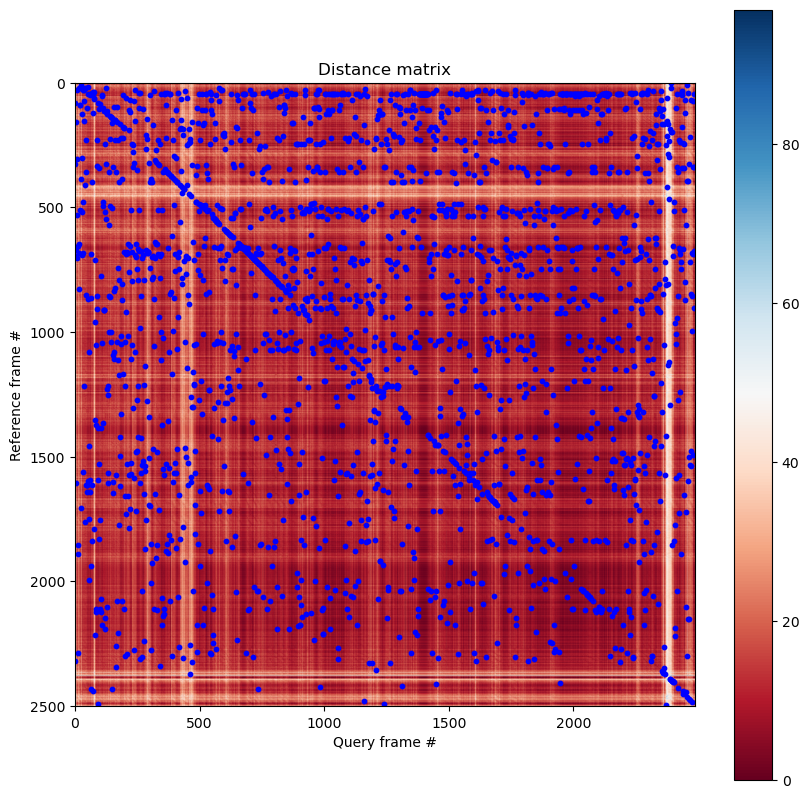

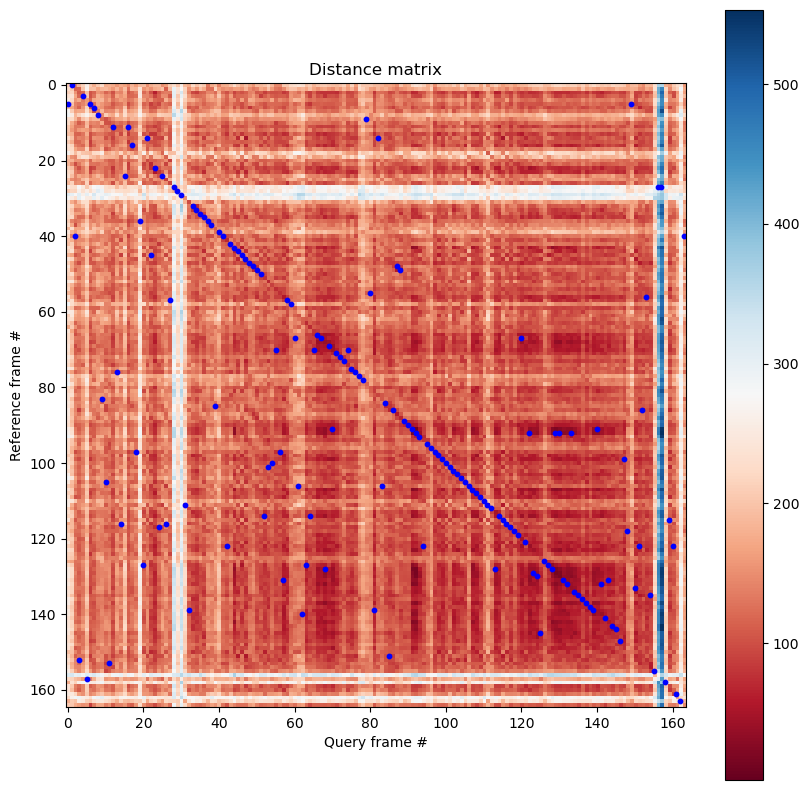

In [18]:
# plot the distance matrix
def plot_distance_matrix(distance_matrix):
    plt.figure(figsize=(10, 10))
    plt.imshow(distance_matrix, aspect='equal', cmap='RdBu')
    plt.colorbar()
    # show best match for each query frame
    best_match = np.argmin(distance_matrix, axis=0)
    # print(best_match.shape)
    plt.scatter(np.arange(len(best_match)), best_match, c='b', s=10)
    plt.xlabel('Query frame #')
    plt.ylabel('Reference frame #')
    plt.title('Distance matrix')
    plt.show()

plot_distance_matrix(distance_matrix_fast_random_pixels_66ms)
plot_distance_matrix(distance_matrix_fast_random_pixels_1000ms)
# plot_distance_matrix(distance_matrix_all_pixels_66ms)

(2502, 2487)


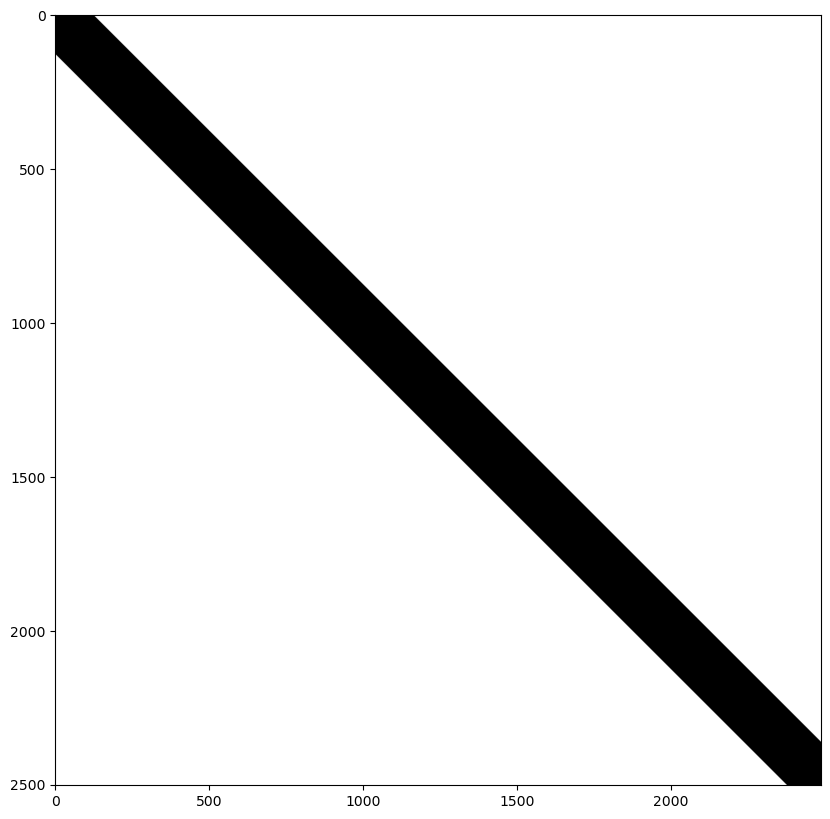

In [19]:
# define ground truth matrix, allowing +-10% tolerance around each reference frame
tolerance = 0.05
ground_truth_matrix_66ms = np.zeros((frames_random_pixels_ref_66ms.shape[0], frames_random_pixels_qry_66ms.shape[0]))
for i in range(frames_random_pixels_qry_66ms.shape[0]):
    for j in range(frames_random_pixels_ref_66ms.shape[0]):
        if np.abs(i - j) <= tolerance * frames_random_pixels_ref_66ms.shape[0]:
            ground_truth_matrix_66ms[j, i] = 1

# now do the same for the 1000ms event frames
ground_truth_matrix_1000ms = np.zeros((frames_random_pixels_ref_1000ms.shape[0], frames_random_pixels_qry_1000ms.shape[0]))
for i in range(frames_random_pixels_qry_1000ms.shape[0]):
    for j in range(frames_random_pixels_ref_1000ms.shape[0]):
        if np.abs(i - j) <= tolerance * frames_random_pixels_ref_1000ms.shape[0]:
            ground_truth_matrix_1000ms[j, i] = 1

plt.figure(figsize=(10, 10))
plt.imshow(ground_truth_matrix_66ms, aspect='equal', cmap='Greys')

print(ground_truth_matrix_66ms.shape)

In [20]:
# calculate accuracy, assuming +-10% tolerance around the correct match

def calculate_accuracy(distance_matrix, ground_truth_matrix):
    best_matches = np.argmin(distance_matrix, axis=0)
    num_correct = 0
    for i in range(len(best_matches)):
        if ground_truth_matrix[best_matches[i], i] == 1:
            num_correct += 1
    accuracy = num_correct / len(best_matches)
    return accuracy

accuracy_random_pixels_66ms = calculate_accuracy(distance_matrix_fast_random_pixels_66ms, ground_truth_matrix_66ms)
print(f'Accuracy random pixels (66ms windows): {accuracy_random_pixels_66ms * 100:.2f}%')

accuracy_random_pixels_1000ms = calculate_accuracy(distance_matrix_fast_random_pixels_1000ms, ground_truth_matrix_1000ms)
print(f'Accuracy random pixels (1000ms windows): {accuracy_random_pixels_1000ms * 100:.2f}%')

# accuracy_all_pixels_66ms = calculate_accuracy(distance_matrix_all_pixels_66ms, ground_truth_matrix_66ms)
# print(f'Accuracy all pixels: {accuracy_all_pixels_66ms * 100:.2f}%')

Accuracy random pixels (66ms windows): 19.94%
Accuracy random pixels (1000ms windows): 60.98%


In [21]:
# Add sequence matcher over the top of the distance matrix
seq_length = 1000//66
print('Using sequence length:', seq_length)

device = torch.device("mps")

precomputed_convWeight = torch.eye(seq_length).unsqueeze(0).unsqueeze(0)
dist_matrix_random_seq_66ms = torch.nn.functional.conv2d(torch.from_numpy(distance_matrix_fast_random_pixels_66ms.astype(np.float32)).unsqueeze(0).unsqueeze(0), precomputed_convWeight).squeeze().cpu().numpy() / seq_length
# Let's keep dimensions for ease the same (padding the borders)
dist_matrix_random_seq_66ms = np.pad(dist_matrix_random_seq_66ms, ((seq_length//2, seq_length//2-1), (seq_length//2, seq_length//2-1)), mode='constant', constant_values=np.inf)

Using sequence length: 15


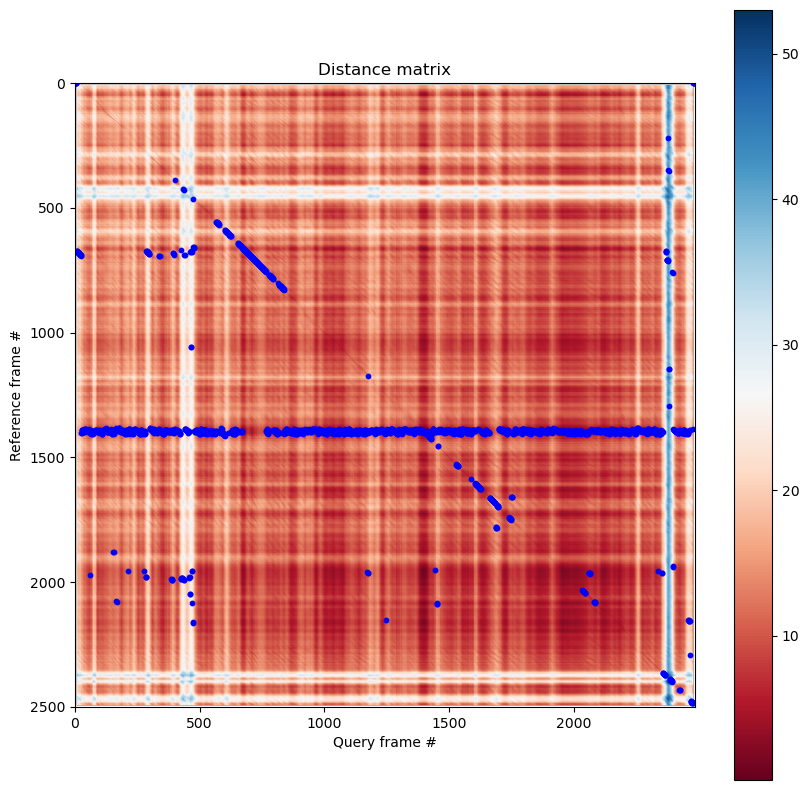

In [22]:
plot_distance_matrix(dist_matrix_random_seq_66ms)

In [23]:
accuracy_random_pixels_seq_66ms = calculate_accuracy(dist_matrix_random_seq_66ms, ground_truth_matrix_66ms)
print(f'Accuracy random pixels sequence matcher 66ms: {accuracy_random_pixels_seq_66ms * 100:.2f}%')

Accuracy random pixels sequence matcher 66ms: 23.57%
